In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb

# from tqdm import tqdm # 如果在普通python脚本环境
from tqdm.notebook import tqdm  # 如果在notebook环境，使用这个导入
import gc
import warnings
from datetime import timedelta

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)  # 忽略一些未来的警告

# --- 1. 数据加载与预处理 ---
print("Loading data...")
dtype_spec = {
    "UserID": "category",
    "UserBehaviour": "int8",
    "BloggerID": "category",
    "Time": "str",
}
# Problem 3只需要附件1的数据
# 注意：如果数据文件不在当前脚本同级目录的'program'文件夹下，请修改路径
try:
    df_hist = pd.read_csv(
        "/Users/pp/projects/51MCM2025/program/a1.csv", dtype=dtype_spec
    )
except FileNotFoundError:
    print("Error: 'program/a1.csv' not found. Please check the file path.")
    exit()

Loading data...


In [72]:

print("Preprocessing data...")
df_hist['Time'] = pd.to_datetime(df_hist['Time'])
df_hist['Date'] = pd.to_datetime(df_hist['Time'].dt.date)

# --- 时间点定义 ---
hist_start_date = pd.to_datetime('2024-07-11')
hist_end_date = pd.to_datetime('2024-07-20') # 历史数据截止日期
predict_date = pd.to_datetime('2024-07-21') # 预测目标日期

print(f"History data range: {hist_start_date.date()} to {hist_end_date.date()}")
print(f"Prediction date: {predict_date.date()}")

# Problem 3 目标用户列表
target_users_p3 = ['U9', 'U22405', 'U16', 'U48420']

print("Data loaded and preprocessed.")
gc.collect()

Preprocessing data...
History data range: 2024-07-11 to 2024-07-20
Prediction date: 2024-07-21
Data loaded and preprocessed.


3227

In [73]:
# --- 辅助函数：构建历史特征 (适配 Problem 3) ---
def create_historical_features(df_hist_subset, reference_date):
    """
    为给定的历史数据子集创建历史特征.
    不包含“当天互动特征”。
    """
    # print(f"Creating historical features based on data up to {reference_date.date()}...") # 移除这个打印，避免进度条混乱

    hist_ref = df_hist_subset[df_hist_subset['Date'] <= reference_date].copy()

    # --- 计算全局/用户/博主级别的聚合特征 ---
    # print("Calculating global/user/blogger features...") # 移除这个打印
    user_agg = hist_ref.groupby('UserID').agg(
        user_hist_interactions=('BloggerID', 'count'),
        user_hist_unique_bloggers=('BloggerID', 'nunique'),
        user_hist_follows=('UserBehaviour', lambda x: (x == 4).sum()),
        user_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        user_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        user_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        user_active_days=('Date', 'nunique'),
        user_first_active_date=('Date', 'min'),
        user_last_active_date=('Date', 'max')
    ).reset_index()
    user_agg['user_follow_rate'] = user_agg['user_hist_follows'] / user_agg['user_hist_interactions'].replace(0, 1)
    user_agg['user_days_since_last_active'] = (reference_date - user_agg['user_last_active_date']).dt.days
    user_agg['user_account_age_days'] = (reference_date - user_agg['user_first_active_date']).dt.days

    blogger_agg = hist_ref.groupby('BloggerID').agg(
        blogger_hist_interactions=('UserID', 'count'),
        blogger_hist_unique_users=('UserID', 'nunique'),
        blogger_hist_follows=('UserBehaviour', lambda x: (x == 4).sum()),
        blogger_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        blogger_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        blogger_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        blogger_active_days=('Date', 'nunique'),
        blogger_first_active_date=('Date', 'min'),
        blogger_last_active_date=('Date', 'max')
    ).reset_index()
    blogger_agg['blogger_follow_rate'] = blogger_agg['blogger_hist_follows'] / blogger_agg['blogger_hist_interactions'].replace(0, 1)
    blogger_agg['blogger_days_since_last_active'] = (reference_date - blogger_agg['blogger_last_active_date']).dt.days
    blogger_agg['blogger_account_age_days'] = (reference_date - blogger_agg['blogger_first_active_date']).dt.days

    gc.collect()

    # --- 计算用户-博主交互特征 ---
    # print("Calculating user-blogger interaction features...") # 移除这个打印
    user_blogger_hist_agg = hist_ref.groupby(['UserID', 'BloggerID']).agg(
        ub_hist_interactions=('Time', 'count'),
        ub_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        ub_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        ub_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        ub_hist_follows=('UserBehaviour', lambda x: (x == 4).sum()), # Add ub follows
        ub_first_interaction_date=('Date', 'min'),
        ub_last_interaction_date=('Date', 'max'),
        ub_interaction_days=('Date', 'nunique')
    ).reset_index()
    user_blogger_hist_agg['ub_days_since_first_interaction'] = (reference_date - user_blogger_hist_agg['ub_first_interaction_date']).dt.days
    user_blogger_hist_agg['ub_days_since_last_interaction'] = (reference_date - user_blogger_hist_agg['ub_last_interaction_date']).dt.days
    user_blogger_hist_agg['ub_interaction_frequency'] = user_blogger_hist_agg['ub_hist_interactions'] / user_blogger_hist_agg['ub_interaction_days'].replace(0, 1)
    user_blogger_hist_agg['ub_follow_rate'] = user_blogger_hist_agg['ub_hist_follows'] / user_blogger_hist_agg['ub_hist_interactions'].replace(0, 1) # Add ub follow rate


    # 删除不再需要的原始日期列
    date_cols_to_drop = [
        'user_first_active_date', 'user_last_active_date',
        'blogger_first_active_date', 'blogger_last_active_date',
        'ub_first_interaction_date', 'ub_last_interaction_date'
    ]
    user_agg = user_agg.drop(columns=[col for col in date_cols_to_drop if col in user_agg.columns], errors='ignore')
    blogger_agg = blogger_agg.drop(columns=[col for col in date_cols_to_drop if col in blogger_agg.columns], errors='ignore')
    user_blogger_hist_agg = user_blogger_hist_agg.drop(columns=[col for col in date_cols_to_drop if col in user_blogger_hist_agg.columns], errors='ignore')


    return user_agg, blogger_agg, user_blogger_hist_agg


In [74]:

# --- 2. 子任务 1: 预测用户 2024.7.21 是否在线 ---
print("\n--- Building Training and Validation Data for Online Prediction ---")
# 训练集：预测 7.20 是否在线，特征基于 7.11-7.19
print("Processing data for online prediction training (Predicting 7.20 based on 7.11-7.19)...")
train_pred_date_online = pd.to_datetime('2024-07-20')
train_hist_end_online = train_pred_date_online - timedelta(days=1) # 7.19
user_features_train_online, _, _ = create_historical_features(df_hist, train_hist_end_online)
# 找到在 7.20 活跃的用户 (训练标签)
active_on_train_date_online = df_hist[df_hist['Date'] == train_pred_date_online]['UserID'].unique()
user_features_train_online['is_online'] = user_features_train_online['UserID'].isin(active_on_train_date_online).astype(int)
# 验证集：预测 7.19 是否在线，特征基于 7.11-7.18
print("Processing data for online prediction validation (Predicting 7.19 based on 7.11-7.18)...")
val_pred_date_online = pd.to_datetime('2024-07-19')
val_hist_end_online = val_pred_date_online - timedelta(days=1) # 7.18
user_features_val_online, _, _ = create_historical_features(df_hist, val_hist_end_online)
# 找到在 7.19 活跃的用户 (验证标签)
active_on_val_date_online = df_hist[df_hist['Date'] == val_pred_date_online]['UserID'].unique()
user_features_val_online['is_online'] = user_features_val_online['UserID'].isin(active_on_val_date_online).astype(int)
gc.collect()
# 填充缺失值 (只对数值列填充)
print("Filling missing values for online training and validation data...")
# 获取所有可能的特征列名 (从训练数据中获取)
all_online_feature_cols = user_features_train_online.columns.difference(['UserID', 'is_online'])
# 填充训练数据
user_features_train_online[all_online_feature_cols] = user_features_train_online[all_online_feature_cols].fillna(0)
# 填充验证数据
user_features_val_online[all_online_feature_cols] = user_features_val_online[all_online_feature_cols].fillna(0)
# 准备训练和验证数据
X_train_online = user_features_train_online[all_online_feature_cols]
y_train_online = user_features_train_online['is_online']
X_val_online = user_features_val_online[all_online_feature_cols]
y_val_online = user_features_val_online['is_online']
print(f"Online prediction training data shape: {X_train_online.shape}, labels shape: {y_train_online.shape}")
print(f"Online prediction validation data shape: {X_val_online.shape}, labels shape: {y_val_online.shape}")
gc.collect()


--- Building Training and Validation Data for Online Prediction ---
Processing data for online prediction training (Predicting 7.20 based on 7.11-7.19)...
Processing data for online prediction validation (Predicting 7.19 based on 7.11-7.18)...
Filling missing values for online training and validation data...
Online prediction training data shape: (19998, 10), labels shape: (19998,)
Online prediction validation data shape: (19998, 10), labels shape: (19998,)


0

In [75]:

print("\n--- Training LightGBM Classifier for Online Prediction ---")
# 定义模型参数
online_lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 1000,
    'n_jobs': -1,
    'seed': 42,
    'is_unbalance': True # 如果正负样本不平衡可以尝试开启
}
online_model = lgb.LGBMClassifier(**online_lgb_params)
print("Starting online model fitting...")
# 在训练集上训练模型
online_model.fit(X_train_online, y_train_online)
print("Online model training finished.")


--- Training LightGBM Classifier for Online Prediction ---
Starting online model fitting...
Online model training finished.



--- Evaluating Online Model on Validation Set and Selecting Threshold ---
Calculating metrics for different thresholds...


Evaluating Thresholds:   0%|          | 0/99 [00:00<?, ?it/s]


Best threshold for F1-score on validation set: 0.1700
F1-score at this threshold: 0.7513
Precision at this threshold: 0.6043
Recall at this threshold: 0.9927

Plot saved as Precision_Recall_F1-Score_vs_Threshold_on_Validation_Set.pdf

Plot saved as online_prediction_metrics_vs_threshold_and_pr_curve.pdf


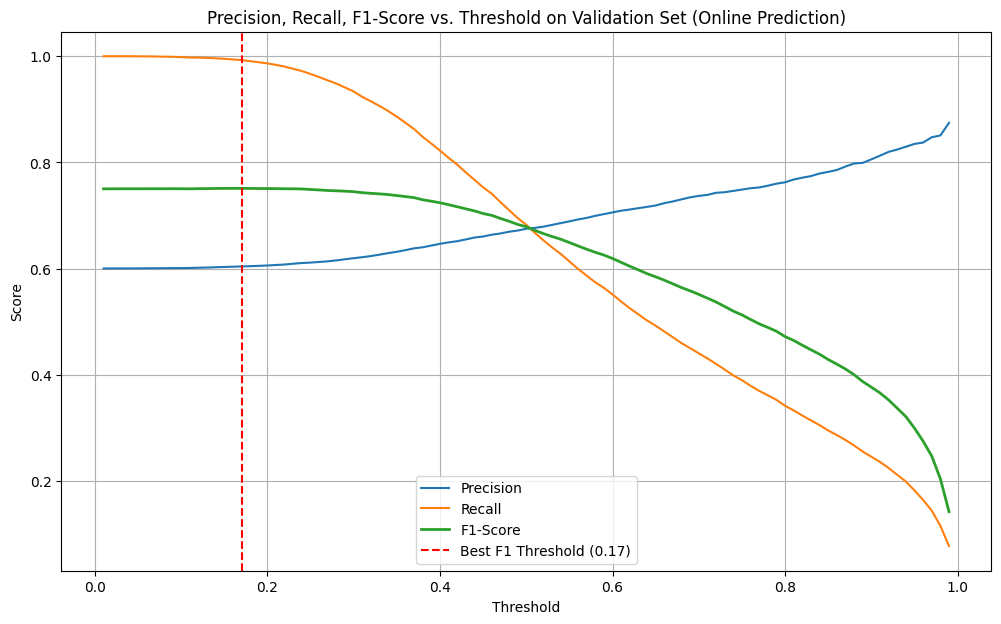

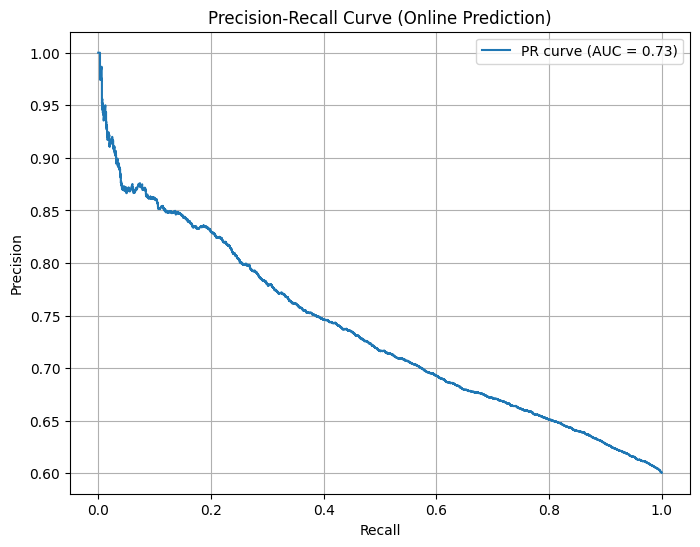

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# --- 在验证集上评估并选择最佳阈值 ---
print("\n--- Evaluating Online Model on Validation Set and Selecting Threshold ---")
# 在验证集上预测概率
y_pred_proba_val_online = online_model.predict_proba(X_val_online)[:, 1]
# 计算 Precision, Recall, F1-Score 随阈值变化
thresholds = np.arange(0.01, 1.0, 0.01) # 候选阈值范围 (从0.01开始避免除零)
precisions = []
recalls = []
f1_scores = []
print("Calculating metrics for different thresholds...")
for thresh in tqdm(thresholds, desc="Evaluating Thresholds"):
    # 将概率按当前阈值转换为 0/1 预测
    y_pred_binary_val = (y_pred_proba_val_online >= thresh).astype(int)
    # 计算指标 (注意 zero_division=0 避免除以零警告)
    precisions.append(precision_score(y_val_online, y_pred_binary_val, zero_division=0))
    recalls.append(recall_score(y_val_online, y_pred_binary_val, zero_division=0))
    f1_scores.append(f1_score(y_val_online, y_pred_binary_val, zero_division=0))
# 找到最佳阈值 (例如，使 F1 分数最高的阈值)
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"\nBest threshold for F1-score on validation set: {best_threshold_f1:.4f}")
print(f"F1-score at this threshold: {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at this threshold: {precisions[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recalls[best_f1_idx]:.4f}")
# 可视化指标随阈值变化
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score vs. Threshold on Validation Set (Online Prediction)")
plt.axvline(best_threshold_f1, color='red', linestyle='--', label=f'Best F1 Threshold ({best_threshold_f1:.2f})')
plt.legend()
plt.grid(True)
pdf_filename_online = "Precision_Recall_F1-Score_vs_Threshold_on_Validation_Set.pdf"
plt.savefig(pdf_filename_online, format='pdf', bbox_inches='tight') # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online}")
# 绘制 PR 曲线 (可选)
precision_pr, recall_pr, _ = precision_recall_curve(y_val_online, y_pred_proba_val_online)
auc_pr = auc(recall_pr, precision_pr)
plt.figure(figsize=(8, 6))
plt.plot(recall_pr, precision_pr, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Online Prediction)')
plt.legend()
plt.grid(True)
# 保存图表
pdf_filename_online = "online_prediction_metrics_vs_threshold_and_pr_curve.pdf"
plt.savefig(pdf_filename_online, format='pdf', bbox_inches='tight') # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online}")
plt.show() # 如果你想在保存后仍然显示图形，取消这行的注释
plt.close('all') # 关闭所有图形，释放内存


In [80]:

# --- 使用选择的最佳阈值进行 7.21 在线预测 ---
final_online_prediction_threshold = 0.6
print(f"\nUsing final online prediction threshold: {final_online_prediction_threshold:.4f}")
print("\n--- Predicting 7.21 Online Status for Target Users ---")
# 为目标用户计算基于 7.11-7.20 的特征
predict_online_users_df = pd.DataFrame({'UserID': target_users_p3})
print("Calculating historical features for target users (up to 7.20)...")
predict_online_features_calc, _, _ = create_historical_features(df_hist, hist_end_date) # 7.20
# 只保留目标用户的特征
predict_online_features = pd.merge(predict_online_users_df, predict_online_features_calc, on='UserID', how='left')
# 填充缺失值 (只对数值列填充)
print("Filling missing values for target user features...")
# 选择需要填充的数值列，排除非数值列 (UserID)
cols_to_fill_pred_online = predict_online_features.columns.difference(['UserID'])
# 使用 fillna(0) 填充这些数值列
predict_online_features[cols_to_fill_pred_online] = predict_online_features[cols_to_fill_pred_online].fillna(0)
# 确保预测特征列与训练特征列一致
# 注意：这里需要使用训练集 (X_train_online) 的列来对齐
predict_online_features = predict_online_features[X_train_online.columns]



Using final online prediction threshold: 0.6000

--- Predicting 7.21 Online Status for Target Users ---
Calculating historical features for target users (up to 7.20)...
Filling missing values for target user features...


In [81]:
# 预测在线概率
online_pred_proba = online_model.predict_proba(predict_online_features)[:, 1]
predict_online_users_df['online_proba'] = online_pred_proba
# 根据选择的阈值判断是否在线
predicted_online_users = predict_online_users_df[predict_online_users_df['online_proba'] >= final_online_prediction_threshold]['UserID'].tolist()
print(f"Predicted {len(predicted_online_users)} target users to be online on 7.21.")
print(f"Predicted online users: {predicted_online_users}")
gc.collect()

Predicted 3 target users to be online on 7.21.
Predicted online users: ['U9', 'U22405', 'U48420']


38


Plot saved as Online_Probability_for_Selected Users.pdf


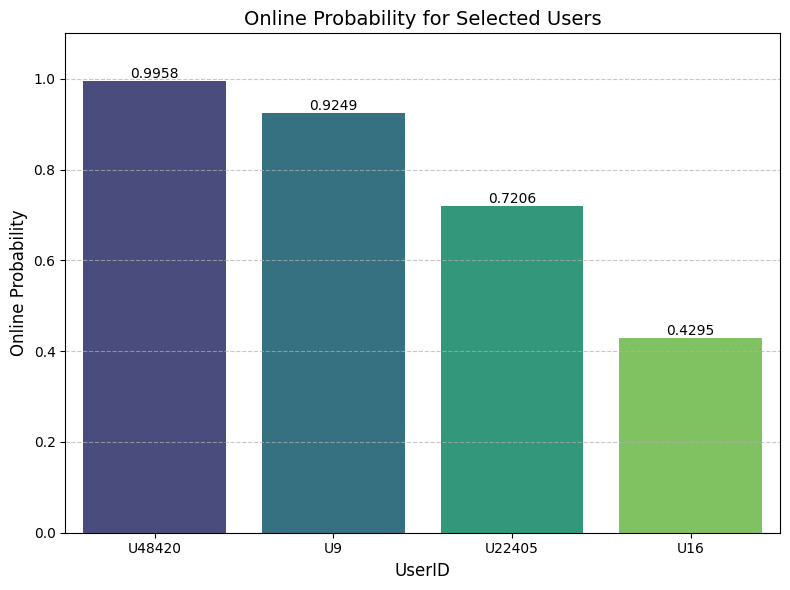

,UserID,online_proba
0,U9,0.924850
1,U22405,0.720643
2,U16,0.429453
3,U48420,0.995767


In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 数据
data = {
    'UserID': ['U9', 'U22405', 'U16', 'U48420'],
    'online_proba': online_pred_proba
}
df = pd.DataFrame(data)

# 为了让图表更清晰，按概率降序排序
# Seaborn 的 barplot 可以直接使用 order 参数，但先排序 DataFrame 也很直观
df_sorted = df.sort_values(by='online_proba', ascending=False)

# 创建图表和轴对象
plt.figure(figsize=(8, 6))
# 使用 seaborn 的 barplot
ax = sns.barplot(x='UserID', y='online_proba', data=df_sorted, palette='viridis') # palette 可以设置颜色主题

# 添加标题和轴标签 (使用 Matplotlib)
plt.title('Online Probability for Selected Users', fontsize=14)
plt.xlabel('UserID', fontsize=12)
plt.ylabel('Online Probability', fontsize=12)
plt.ylim(0, 1.1) # 设置Y轴范围

# 在每个柱子上方显示具体的概率值 (使用 Matplotlib 和轴对象)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', # 格式化概率值，保留4位小数
                (p.get_x() + p.get_width() / 2., p.get_height()), # 文本位置 (x, y)
                ha='center', va='center', # 水平垂直对齐
                xytext=(0, 5), # 文本相对于位置的偏移量 (x, y)
                textcoords='offset points')

# 显示网格线 (可选)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 自动调整布局，防止文本重叠
plt.tight_layout()

pdf_filename_online = "Online_Probability_for_Selected Users.pdf"
plt.savefig(pdf_filename_online, format='pdf', bbox_inches='tight') # format='pdf' 指定格式, bbox_inches='tight' 尝试去除多余边距
print(f"\nPlot saved as {pdf_filename_online}")

# 显示图表
plt.show()

predict_online_users_df


In [93]:
import pandas as pd

# 假设 predict_online_users_df 已经加载并包含了 'UserID' 和 'online_proba' 列
# 请确保 predict_online_users_df 已经准备好
# 例如，如果它是从文件加载的：
# try:
#     predict_online_users_df = pd.read_csv('your_predictions.csv') # 请替换成您实际的文件路径
# except FileNotFoundError:
#     print("错误：预测结果文件未找到。请确认文件路径是否正确。")
#     # 或者确保 predict_online_users_df 是通过运行之前的模型预测代码生成的

# 假设 predict_online_users_df 已经存在于当前环境中

# 定义最佳 F1 阈值 (从图表中读取)
threshold = 0.17

# 确认 DataFrame 存在并包含必要的列
if 'predict_online_users_df' in locals() and isinstance(predict_online_users_df, pd.DataFrame) and 'online_proba' in predict_online_users_df.columns:
    # 根据阈值进行分类预测
    # 大于等于阈值的为 True (预测在线)，小于阈值的为 False (预测不在线)
    predict_online_users_df['predicted_online'] = predict_online_users_df['online_proba'] >= threshold

    print(f"已根据阈值 {threshold} 为所有用户添加了 'predicted_online' 列。")

    # 显示部分预测结果（前几行）
    print("\n部分预测结果 (前5行):")
    print(predict_online_users_df.head())

    # 显示部分预测为在线的用户
    print("\n部分预测为在线的用户 (前5行):")
    print(predict_online_users_df[predict_online_users_df['predicted_online'] == True].head())

    # 显示部分预测为不在线的用户
    print("\n部分预测为不在线的用户 (前5行):")
    print(predict_online_users_df[predict_online_users_df['predicted_online'] == False].head())

    # 如果用户数量很多，直接打印不方便，建议保存到文件
    output_filename = 'all_user_predictions_with_status.csv'
    predict_online_users_df.to_csv(output_filename, index=False)
    print(f"\n所有用户的预测结果已保存到文件: {output_filename}")


else:
    print("错误：找不到 predict_online_users_df DataFrame，或者它不包含 'online_proba' 列。请确保您已经运行了生成预测的代码，并且 DataFrame 名称正确。")



已根据阈值 0.17 为所有用户添加了 'predicted_online' 列。

部分预测结果 (前5行):
   UserID  online_proba  predicted_online
0      U9      0.924850              True
1  U22405      0.720643              True
2     U16      0.429453              True
3  U48420      0.995767              True

部分预测为在线的用户 (前5行):
   UserID  online_proba  predicted_online
0      U9      0.924850              True
1  U22405      0.720643              True
2     U16      0.429453              True
3  U48420      0.995767              True

部分预测为不在线的用户 (前5行):
Empty DataFrame
Columns: [UserID, online_proba, predicted_online]
Index: []

所有用户的预测结果已保存到文件: all_user_predictions_with_status.csv


In [83]:

# --- 3. 子任务 2: 预测在线用户的互动博主 (Top 3) ---
print("\n--- Building Training Data for Interaction Prediction ---")
# 构建训练数据：预测 7.19 和 7.20 的互动总数，特征基于前一天
interaction_train_data = []
# 训练样本 1: 预测 7.19 的互动总数，特征基于 7.11-7.18
print("Processing data for interaction prediction training (Predicting 7.19 based on 7.11-7.18)...")
inter_date_1 = pd.to_datetime('2024-07-19')
hist_end_1_inter = inter_date_1 - timedelta(days=1) # 7.18
# 找到在 7.19 发生互动 (2,3,4) 的 (UserID, BloggerID) 对
interaction_on_date_1 = df_hist[(df_hist['Date'] == inter_date_1) & (df_hist['UserBehaviour'].isin([2, 3, 4]))].copy()
# 计算每个对的总互动数 (2,3,4) 作为标签
interaction_labels_1 = interaction_on_date_1.groupby(['UserID', 'BloggerID']).size().reset_index(name='total_interaction_count')
interaction_labels_1['inter_date'] = inter_date_1
# 计算这些对的特征 (基于 7.11-7.18)
user_agg_1_inter, blogger_agg_1_inter, ub_agg_1_inter = create_historical_features(df_hist, hist_end_1_inter)
# 合并特征和标签
print("Merging features and labels for 7.19 interaction training...")
interaction_features_1 = pd.merge(interaction_labels_1, user_agg_1_inter, on='UserID', how='left')
interaction_features_1 = pd.merge(interaction_features_1, blogger_agg_1_inter, on='BloggerID', how='left')
interaction_features_1 = pd.merge(interaction_features_1, ub_agg_1_inter, on=['UserID', 'BloggerID'], how='left')
interaction_train_data.append(interaction_features_1)
gc.collect()



--- Building Training Data for Interaction Prediction ---
Processing data for interaction prediction training (Predicting 7.19 based on 7.11-7.18)...
Merging features and labels for 7.19 interaction training...


34

In [84]:

# 训练样本 2: 预测 7.20 的互动总数，特征基于 7.11-7.19
print("Processing data for interaction prediction training (Predicting 7.20 based on 7.11-7.19)...")
inter_date_2 = pd.to_datetime('2024-07-20')
hist_end_2_inter = inter_date_2 - timedelta(days=1) # 7.19
# 找到在 7.20 发生互动 (2,3,4) 的 (UserID, BloggerID) 对
interaction_on_date_2 = df_hist[(df_hist['Date'] == inter_date_2) & (df_hist['UserBehaviour'].isin([2, 3, 4]))].copy()
# 计算每个对的总互动数 (2,3,4) 作为标签
interaction_labels_2 = interaction_on_date_2.groupby(['UserID', 'BloggerID']).size().reset_index(name='total_interaction_count')
interaction_labels_2['inter_date'] = inter_date_2
# 计算这些对的特征 (基于 7.11-7.19)
user_agg_2_inter, blogger_agg_2_inter, ub_agg_2_inter = create_historical_features(df_hist, hist_end_2_inter)
# 合并特征和标签
print("Merging features and labels for 7.20 interaction training...")
interaction_features_2 = pd.merge(interaction_labels_2, user_agg_2_inter, on='UserID', how='left')
interaction_features_2 = pd.merge(interaction_features_2, blogger_agg_2_inter, on='BloggerID', how='left')
interaction_features_2 = pd.merge(interaction_features_2, ub_agg_2_inter, on=['UserID', 'BloggerID'], how='left')
interaction_train_data.append(interaction_features_2)
gc.collect()

Processing data for interaction prediction training (Predicting 7.20 based on 7.11-7.19)...
Merging features and labels for 7.20 interaction training...


34

In [85]:
# 合并训练数据
print("Concatenating interaction training data...")
interaction_train_df = pd.concat(interaction_train_data, ignore_index=True)
# 填充缺失值 (只对数值列填充)
print("Filling missing values for interaction training data...")
# 选择需要填充的数值列，排除非数值列 (UserID, BloggerID, total_interaction_count, inter_date)
cols_to_fill_interaction = interaction_train_df.columns.difference(['UserID', 'BloggerID', 'total_interaction_count', 'inter_date'])
# 使用 fillna(0) 填充这些数值列
interaction_train_df[cols_to_fill_interaction] = interaction_train_df[cols_to_fill_interaction].fillna(0)
# 准备训练数据
interaction_labels = interaction_train_df['total_interaction_count']
interaction_features = interaction_train_df.drop(columns=['UserID', 'BloggerID', 'total_interaction_count', 'inter_date'])
# 确保列名一致
feature_cols_interaction = interaction_features.columns.tolist()
print(f"Interaction prediction training data shape: {interaction_features.shape}, labels shape: {interaction_labels.shape}")
gc.collect()


Concatenating interaction training data...
Filling missing values for interaction training data...
Interaction prediction training data shape: (1679832, 30), labels shape: (1679832,)


0

In [86]:

print("\n--- Training LightGBM Regressor for Interaction Prediction ---")
# 定义模型参数
interaction_lgb_params = {
    'objective': 'regression_l1', # 预测计数，使用L1损失或L2损失
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 1000,
    'n_jobs': -1,
    'seed': 42,
}
interaction_model = lgb.LGBMRegressor(**interaction_lgb_params)
print("Starting interaction model fitting...")
interaction_model.fit(interaction_features, interaction_labels)
print("Interaction model training finished.")



--- Training LightGBM Regressor for Interaction Prediction ---
Starting interaction model fitting...
Interaction model training finished.


In [87]:

# --- 进行 7.21 互动预测 ---
print("\n--- Predicting Top 3 Interaction Bloggers for Online Users on 7.21 ---")
problem3_results = {user_id: [] for user_id in target_users_p3}
if predicted_online_users:
    print(f"Processing predicted online users: {predicted_online_users}")
    # 为每个预测为在线的用户，生成候选博主列表
    # 候选博主：该用户在 7.11-7.20 期间互动过的所有博主
    candidate_pairs_list = []
    print("Generating candidate user-blogger pairs for prediction...")
    # 使用 tqdm 包装外部循环
    for user_id in tqdm(predicted_online_users, desc="Generating pairs"):
        user_hist_df = df_hist[df_hist['UserID'] == user_id].copy()
        if not user_hist_df.empty:
            # 考虑所有行为类型作为历史互动过的博主
            interacted_bloggers = user_hist_df['BloggerID'].unique().tolist()
            for blogger_id in interacted_bloggers:
                # 确保 BloggerID 是字符串以便后续处理
                candidate_pairs_list.append({'UserID': user_id, 'BloggerID': str(blogger_id)})
    if candidate_pairs_list:
        predict_interaction_df = pd.DataFrame(candidate_pairs_list)
        print("Calculating historical features for prediction pairs (up to 7.20)...")
        user_agg_pred, blogger_agg_pred, ub_agg_pred = create_historical_features(df_hist, hist_end_date) # 7.20
        print("Merging features for prediction pairs...")
        predict_interaction_features = pd.merge(predict_interaction_df, user_agg_pred, on='UserID', how='left')
        predict_interaction_features = pd.merge(predict_interaction_features, blogger_agg_pred, on='BloggerID', how='left')
        predict_interaction_features = pd.merge(predict_interaction_features, ub_agg_pred, on=['UserID', 'BloggerID'], how='left')
        # 填充缺失值 (只对数值列填充)
        print("Filling missing values for prediction features...")
        # 选择需要填充的数值列，排除非数值列 (UserID, BloggerID)
        cols_to_fill_pred_inter = predict_interaction_features.columns.difference(['UserID', 'BloggerID'])
        # 使用 fillna(0) 填充这些数值列
        predict_interaction_features[cols_to_fill_pred_inter] = predict_interaction_features[cols_to_fill_pred_inter].fillna(0)
        # 确保预测特征列与训练特征列一致且顺序相同
        # 需要处理训练集中可能存在的但预测集中没有的列，反之亦然
        # 简单方法是只保留训练集中存在的特征列
        predict_interaction_features = predict_interaction_features[feature_cols_interaction]
        print(f"Prediction data shape: {predict_interaction_features.shape}")
        print("Predicting interaction counts for candidate pairs...")
        # 预测互动总数
        predicted_interaction_counts = interaction_model.predict(predict_interaction_features)
        predict_interaction_df['predicted_interaction_count'] = predicted_interaction_counts
        # 对预测互动数为负数的情况进行处理，将其设为0 (互动数不能为负)
        predict_interaction_df['predicted_interaction_count'] = predict_interaction_df['predicted_interaction_count'].apply(lambda x: max(0, x))
        print("Ranking bloggers and selecting Top 3 for each user...")
        # 按用户分组，选择预测互动数最高的 Top 3 博主
        # 使用 tqdm 包装 groupby 后的迭代
        for user_id, user_predictions in tqdm(predict_interaction_df.groupby('UserID'), desc="Selecting Top 3 Bloggers"):
            user_predictions = user_predictions.sort_values(by='predicted_interaction_count', ascending=False)
            top_bloggers = user_predictions['BloggerID'].tolist()[:3]
            # 确保博主ID转换为字符串
            problem3_results[user_id] = [str(bid) for bid in top_bloggers]
    else:
        print("No historical interaction pairs found for predicted online users.")
else:
    print("No target users predicted to be online on 7.21. Skipping interaction prediction.")
gc.collect()



--- Predicting Top 3 Interaction Bloggers for Online Users on 7.21 ---
Processing predicted online users: ['U9', 'U22405', 'U48420']
Generating candidate user-blogger pairs for prediction...


Generating pairs:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating historical features for prediction pairs (up to 7.20)...
Merging features for prediction pairs...
Filling missing values for prediction features...
Prediction data shape: (64, 30)
Predicting interaction counts for candidate pairs...
Ranking bloggers and selecting Top 3 for each user...


Selecting Top 3 Bloggers:   0%|          | 0/3 [00:00<?, ?it/s]

43

In [88]:

# --- 4. 格式化输出结果 (表3) ---
print("\n--- Generating Final Results for Table 3 ---")
# 创建结果DataFrame
table3_data = []
for user_id in target_users_p3:
    # 即使用户没有被预测为在线，或没有互动博主，也需要在表中包含他们，并留空博主列
    bloggers = problem3_results.get(user_id, [])
    row = {'用户ID': user_id}
    for i in range(3):
        row[f'博主ID {i+1}'] = bloggers[i] if i < len(bloggers) else '' # 如果不足3个则留空
    table3_data.append(row)
table3_df = pd.DataFrame(table3_data)
print("\n--- 问题3 预测结果 ---")
print(table3_df.to_string(index=False))


--- Generating Final Results for Table 3 ---

--- 问题3 预测结果 ---
  用户ID 博主ID 1 博主ID 2 博主ID 3
    U9     B3    B23    B13
U22405    B47    B59    B52
   U16                     
U48420     B5    B21     B2
